<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/SVM_WITH_K-FPLD%20FINAL_finito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [4]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [5]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [6]:
import pandas as pd

In [7]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [8]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [9]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test validate splite

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.20,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [12]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [13]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [14]:
shape = (32,32,3)

### GoogleNet

In [15]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [16]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [17]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [18]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [19]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [20]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])
"""
out = Dense(64,activation='relu')(out)
out = Dropout(0.340)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)"""

"\nout = Dense(64,activation='relu')(out)\nout = Dropout(0.340)(out)\nout = Dense(128,activation='relu')(out)\nout = Dropout(0.45)(out)\nout = Dense(256,activation='relu')(out)\n#out = Dropout(0.50)(out)\n\n\noutput = Dense(8,activation='softmax')(out)"

In [21]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = out)

In [22]:
print("Feature extraction ...Training")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...Training


(5653, 480)

In [23]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [24]:
#print("Feature extraction ...validation")
#prediction_v = np.array(e_model.predict([x_v,x_v]))
#prediction_v.shape

In [25]:
#Xvalidate = np.reshape(prediction_v, (prediction_v.shape[0], prediction_v.shape[1]))

In [26]:
print("Feature extraction ...Testing")
prediction_tes = np.array(e_model.predict([x_te,x_te]))

Feature extraction ...Testing


In [27]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [28]:
print('\tFeatures training shape: ', Xtrain.shape)
#print('\tFeatures testing shape: ', Xvalidate.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (5653, 480)
	Features testing shape:  (1414, 480)


In [29]:
C_range = np.logspace(-2, 10, 10)
gamma_range = np.logspace(-9, 3,10)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(Xtrain, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02,
       2.15443469e+03, 4.64158883e+04, 1.00000000e+06, 2.15443469e+07,
       4.64158883e+08, 1.00000000e+10]),
                         'gamma': array([1.00000000e-09, 2.15443469e-08, 4.64158883e-07, 1.00000000e-05,
       2.15443469e-04, 4.64158883e-03, 1.00000000e-01, 2.15443469e+00,
       4.64158883e+01, 1.00000000e+03])})

In [30]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 2154.4346900318824, 'gamma': 0.1} with a score of 0.96


In [31]:
df = pd.DataFrame(grid.cv_results_)
mask = df['rank_test_score']<10
newdf = df[mask]
newdf[['param_C','param_gamma','mean_test_score','std_test_score','rank_test_score']]

,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
37,100.0,2.154435,0.955245,0.005075,3
46,2154.43469,0.1,0.957190,0.004994,1
55,46415.888336,0.004642,0.956660,0.005173,2
56,46415.888336,0.1,0.953475,0.004106,5
64,1000000.0,0.000215,0.954537,0.005298,4
66,1000000.0,0.1,0.952590,0.004685,6
76,21544346.900319,0.1,0.952590,0.004685,6
86,464158883.361277,0.1,0.952590,0.004685,6
96,10000000000.0,0.1,0.952590,0.004685,6


### SVM 

In [32]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

In [ ]:
svm = SVC(kernel='rbf',C=2154.4346900318824,gamma=0.1)
svm.fit(Xtrain, y_tr)

SVC(C=46415.888336127726, gamma=1000)

	Training Accuracy of SVM: 0.8257


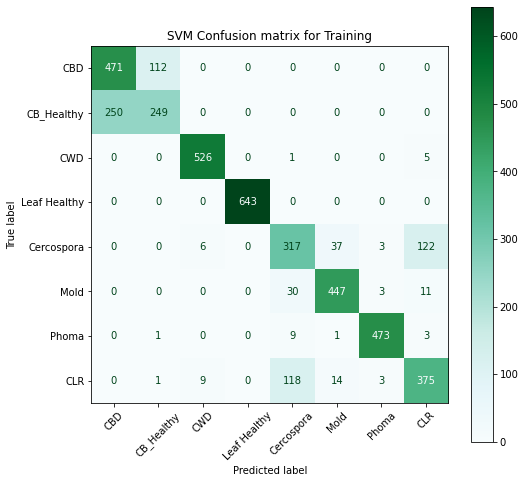

In [ ]:
    predict_train = svm.predict(Xtrain)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_train, np.ravel(y_tr, order='C'))
    print("\tTraining Accuracy of SVM: %0.4f" % acc)
    cm = confusion_matrix(y_tr, predict_train, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("SVM Confusion matrix for Training")
    plt.show()

predicting values for SVM Testing
	Testing Accuracy of SVM: 0.7990


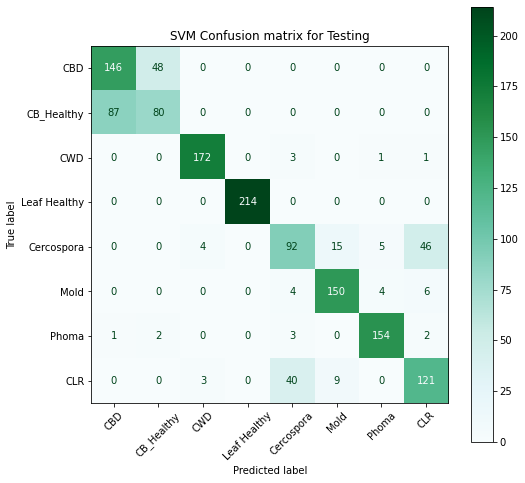

In [ ]:
    print('predicting values for SVM Testing')
    predict_validate = svm.predict(Xvalidate)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_validate, np.ravel(y_v, order='C'))
    print("\tTesting Accuracy of SVM: %0.4f" % acc)
    cm = confusion_matrix(y_v, predict_validate, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("SVM Confusion matrix for Testing")
    plt.show()

predicting values for SVM Validation
	Validation Accuracy of SVM: 0.8034


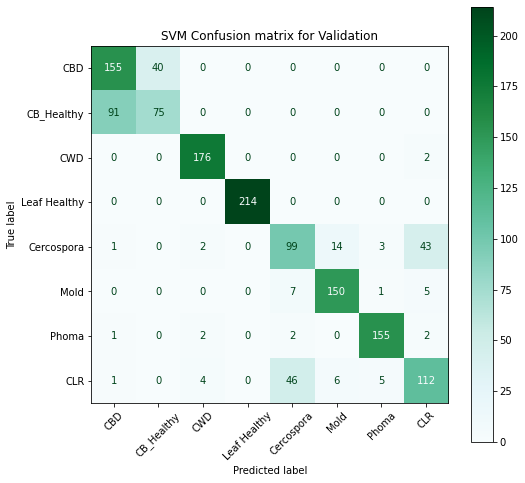

In [ ]:
    print('predicting values for SVM Validation')
    predict_test = svm.predict(Xtest)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_test, np.ravel(y_tes, order='C'))
    print("\tValidation Accuracy of SVM: %0.4f" % acc)
    cm = confusion_matrix(y_tes, predict_test, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("SVM Confusion matrix for Validation")
    plt.show()

In [ ]:
print('classification report for Testing')
print(classification_report(y_v,predict_validate,target_names=target_names))

classification report for Testing
              precision    recall  f1-score   support

         CBD       0.62      0.75      0.68       194
  CB_Healthy       0.62      0.48      0.54       167
         CWD       0.96      0.97      0.97       177
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.65      0.57      0.61       162
        Mold       0.86      0.91      0.89       164
       Phoma       0.94      0.95      0.94       162
         CLR       0.69      0.70      0.69       173

    accuracy                           0.80      1413
   macro avg       0.79      0.79      0.79      1413
weighted avg       0.80      0.80      0.80      1413



In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD',3: 'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

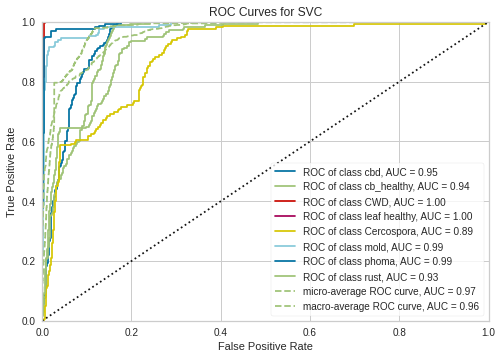

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb09a549550>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=SVC(C=46415.888336127726, gamma=1000))

In [ ]:
plot_ROC_curve(svm,Xtrain,y_tr,Xtest,y_tes)

In [33]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
#skfolds = KFold(n_splits=3)

In [34]:
svm = SVC(kernel='rbf',C=2154.43,gamma=0.1)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    svm.fit(x_tr, y_trin)
    predicted_labels = svm.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = svm.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[   0    2    4 ... 5649 5651 5652] having : 3768
[   1    3    8 ... 5645 5648 5650] having : 1885
iteration 0
folds  1
[   1    2    3 ... 5649 5650 5651] having : 3769
[   0    4    7 ... 5643 5647 5652] having : 1884
iteration 1
folds  2
[   0    1    3 ... 5648 5650 5652] having : 3769
[   2    5    6 ... 5646 5649 5651] having : 1884
iteration 2


In [35]:
labeles = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

	Training Accuracy of SVM: 0.9878


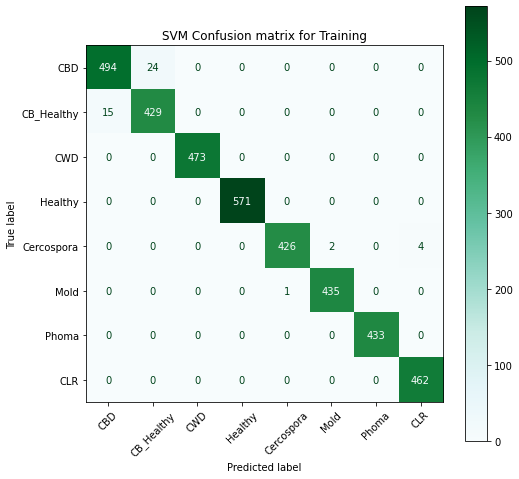

In [36]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of SVM: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("SVM Confusion matrix for Training")
    plt.show()

	Validation Accuracy of SVM: 0.9570


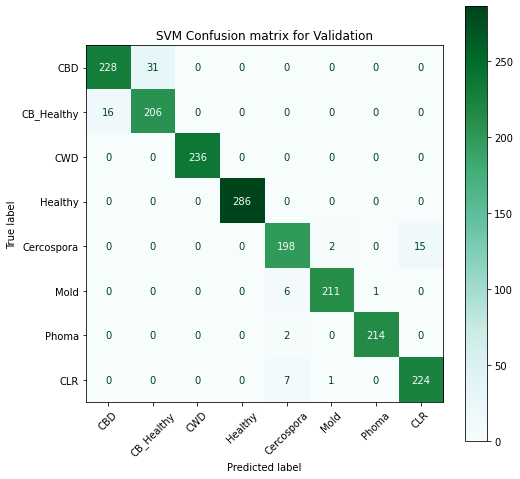

In [37]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tValidation Accuracy of SVM: %0.4f" % acc)
    
    cm = confusion_matrix(actual_targets, predicted_targets, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("SVM Confusion matrix for Validation")
    plt.show()

In [38]:
result = svm.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_te, order='C'))
print("\tTesting Accuracy of SVM: %0.4f" % acc)
print(classification_report(y_te,result,target_names=target_names))

	Testing Accuracy of SVM: 0.9583
              precision    recall  f1-score   support

         CBD       0.93      0.91      0.92       195
  CB_Healthy       0.90      0.92      0.91       166
         CWD       1.00      1.00      1.00       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.91      0.93      0.92       162
        Mold       0.99      0.98      0.98       164
       Phoma       0.99      0.99      0.99       162
         CLR       0.95      0.93      0.94       173

    accuracy                           0.96      1414
   macro avg       0.96      0.96      0.96      1414
weighted avg       0.96      0.96      0.96      1414



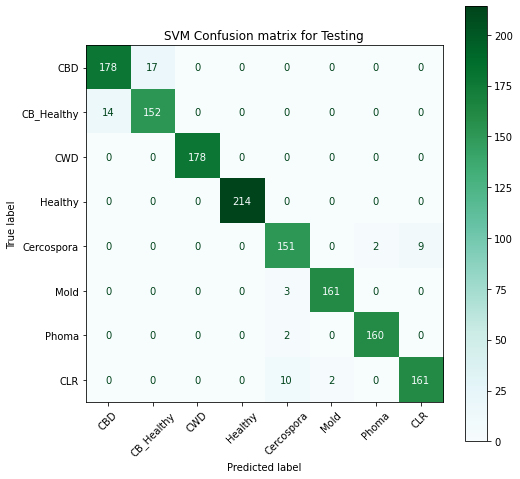

In [39]:
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("SVM Confusion matrix for Testing")
    plt.show()

In [40]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix

In [41]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2:'CWD',3: 'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

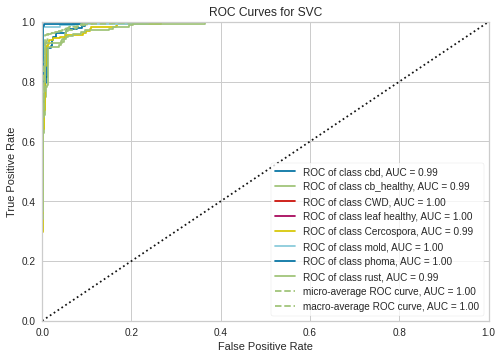

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c601ac590>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=SVC(C=2154.43, gamma=0.1))

In [42]:
plot_ROC_curve(svm,Xtrain,y_tr,Xtest,y_te)